In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from datetime import date, datetime
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.style.use('seaborn-deep')

## Definition of censoring and death

Quitting is death, all else is censoring. This is different than the [original article](https://fivethirtyeight.com/features/two-years-in-turnover-in-trumps-cabinet-is-still-historically-high/)'s author's rules, who stated that switching roles _within_ a cabinent is an "event". 

In [3]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/cabinet-turnover/cabinet-turnover.csv",
                    na_values=['Still in office', '#VALUE!']
                    )
TODAY = datetime.today().date()

INAUG_DATES = {
    'Trump': date(2017, 1, 20),
    'Obama': date(2009, 1, 20),
    'Bush 43': date(2001, 1, 20),
    'Clinton': date(1993, 1, 20),
    'Bush 41': date(1989, 1, 20),
    'Reagan': date(1981, 1, 20),
    'Carter': date(1977, 1, 20)
}

presidential_terms = pd.DataFrame(list(INAUG_DATES.items()))
presidential_terms.columns = ['president', 'president_start_date']
presidential_terms['president_end_date'] = presidential_terms['president_start_date'].shift(1).fillna(TODAY)
presidential_terms

,president,president_start_date,president_end_date
0,Trump,2017-01-20,2019-02-11
1,Obama,2009-01-20,2017-01-20
2,Bush 43,2001-01-20,2009-01-20
3,Clinton,1993-01-20,2001-01-20
4,Bush 41,1989-01-20,1993-01-20
5,Reagan,1981-01-20,1989-01-20
6,Carter,1977-01-20,1981-01-20


In [4]:
def fill_end(series):
    end, president = series
    if pd.notnull(end) and end.endswith('admin'):
        next_pres ,_ = end.split(' ')
        if next_pres == 'Bush':
            next_pres = next_pres + ' 43' if president == 'Clinton' else next_pres + ' 41'
        return INAUG_DATES[next_pres].strftime('%m/%d/%y')
    else:
        return end
    
def fill_start(series):
    end, president = series
    if pd.notnull(end) and end.endswith('admin'):
        prev_pres ,_ = end.split(' ')
        if prev_pres == 'Bush':
            prev_pres = prev_pres + ' 43' if president == 'Obama' else prev_pres + ' 41'
        return INAUG_DATES[president].strftime('%m/%d/%y')
    else:
        return end
    
    
raw_df['end'] = raw_df[['end', 'president']].apply(fill_end, axis=1)
raw_df['start'] = raw_df[['start', 'president']].apply(fill_start, axis=1)

raw_df['end'] = pd.to_datetime(raw_df['end']).dt.date
raw_df['end'] = raw_df['end'].fillna(TODAY)
raw_df['start'] = pd.to_datetime(raw_df['start']).dt.date

In [5]:
raw_df = raw_df.merge(presidential_terms, left_on='president', right_on='president')
raw_df['event'] = (raw_df['end'] < raw_df['president_end_date']) & pd.notnull(raw_df['end'])


In [6]:
# we need to "collapse" individuals into rows, because they may change positions, but that's not quitting...
def collapse(df):
    return df.groupby('appointee', as_index=False).aggregate({
        'start': 'min', 'end': 'max', 'event': 'all', 'president': 'last', 'president_end_date': 'last'
    })

raw_df = raw_df.groupby('president', as_index=False).apply(collapse).reset_index(drop=True)
raw_df['T'] = (raw_df['end'] - raw_df['start']).dt.days


In [7]:
raw_df.tail(20)

,appointee,start,end,event,president,president_end_date,T
267,Jeff Sessions,2017-02-09,2018-11-07,True,Trump,2019-02-11,636
268,Jim Mattis,2017-01-20,2018-12-31,True,Trump,2019-02-11,710
269,John Kelly,2017-01-20,2018-12-31,True,Trump,2019-02-11,710
270,Kirstjen Nielsen,2017-12-06,2019-02-11,False,Trump,2019-02-11,432
271,Linda McMahon,2017-02-14,2019-02-11,False,Trump,2019-02-11,727
272,Mick Mulvaney,2017-02-16,2019-02-11,False,Trump,2019-02-11,725
273,Mike Pence,2017-01-20,2019-02-11,False,Trump,2019-02-11,752
274,Mike Pompeo,2017-01-23,2019-02-11,False,Trump,2019-02-11,749
275,Nikki Haley,2017-01-27,2018-12-31,True,Trump,2019-02-11,703
276,Reince Priebus,2017-01-20,2017-07-28,True,Trump,2019-02-11,189


<lifelines.PiecewiseExponentialFitter: fitted with 287 observations, 129 censored>
number of subjects = 287
  number of events = 158
    log-likelihood = -4.565
        hypothesis = lambda_0_ != 1, lambda_1_ != 1, lambda_2_ != 1

---
            coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
lambda_0_ 0.0003    0.0000      0.0003      0.0004 <5e-05       inf
lambda_1_ 0.0065    0.0013      0.0040      0.0090 <5e-05       inf
lambda_2_ 0.0009    0.0002      0.0006      0.0012 <5e-05       inf


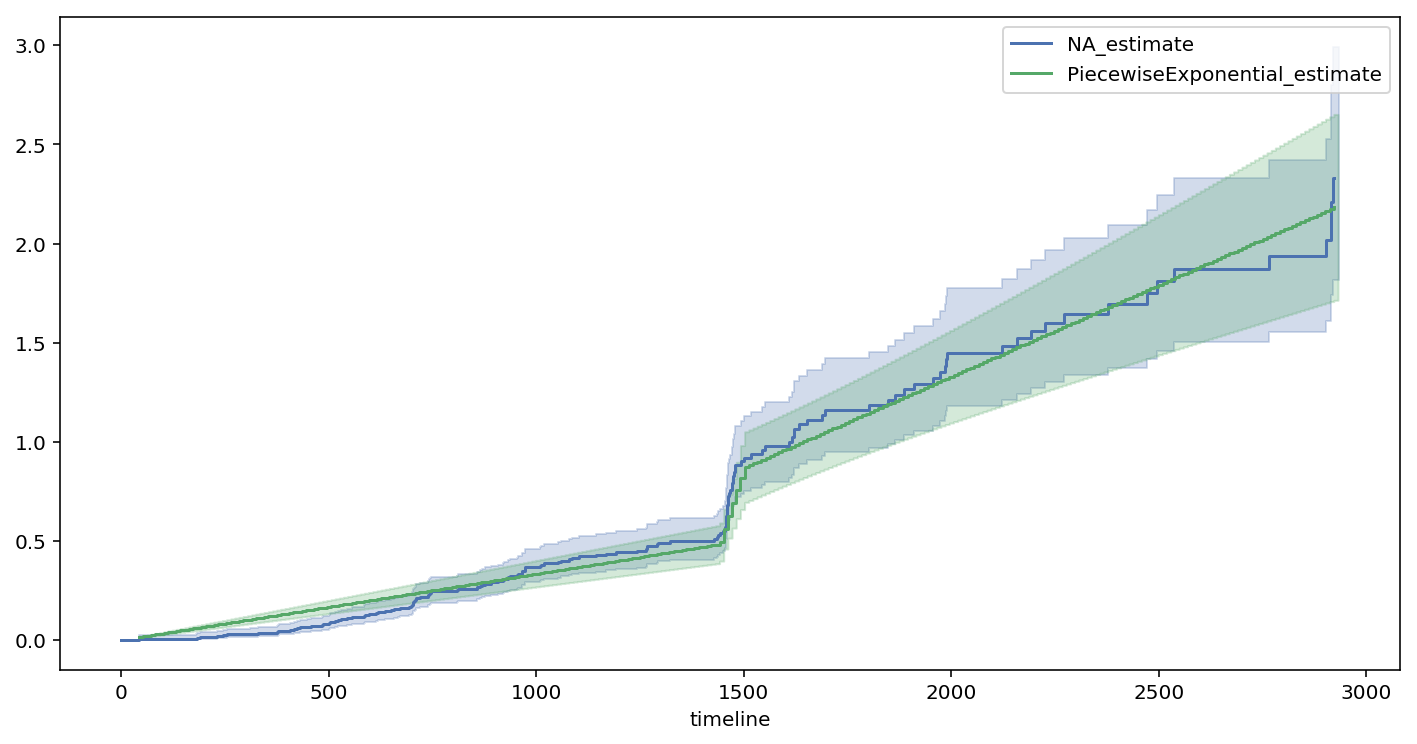

In [26]:
naf = NelsonAalenFitter()
ax = naf.fit(raw_df['T'],raw_df['event']).plot()

from lifelines import PiecewiseExponentialFitter
pf = PiecewiseExponentialFitter(breakpoints=[1440, 1500])
pf.fit(raw_df['T'], raw_df['event'])
pf.plot(ax=ax)
pf.print_summary(4)

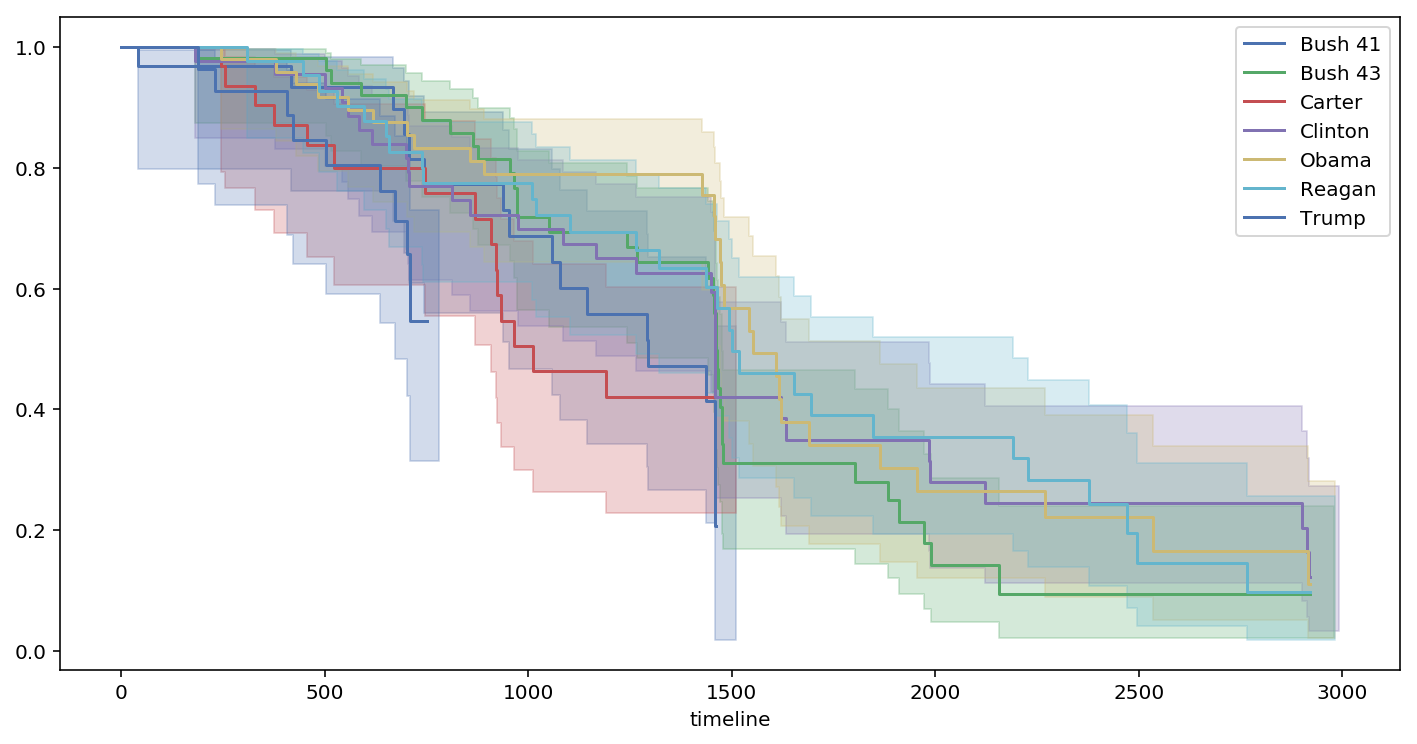

In [8]:
kmf = KaplanMeierFitter()

ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    kmf.fit(df_['T'], df_['event'], label=name)
    ax = kmf.plot(ax=ax)


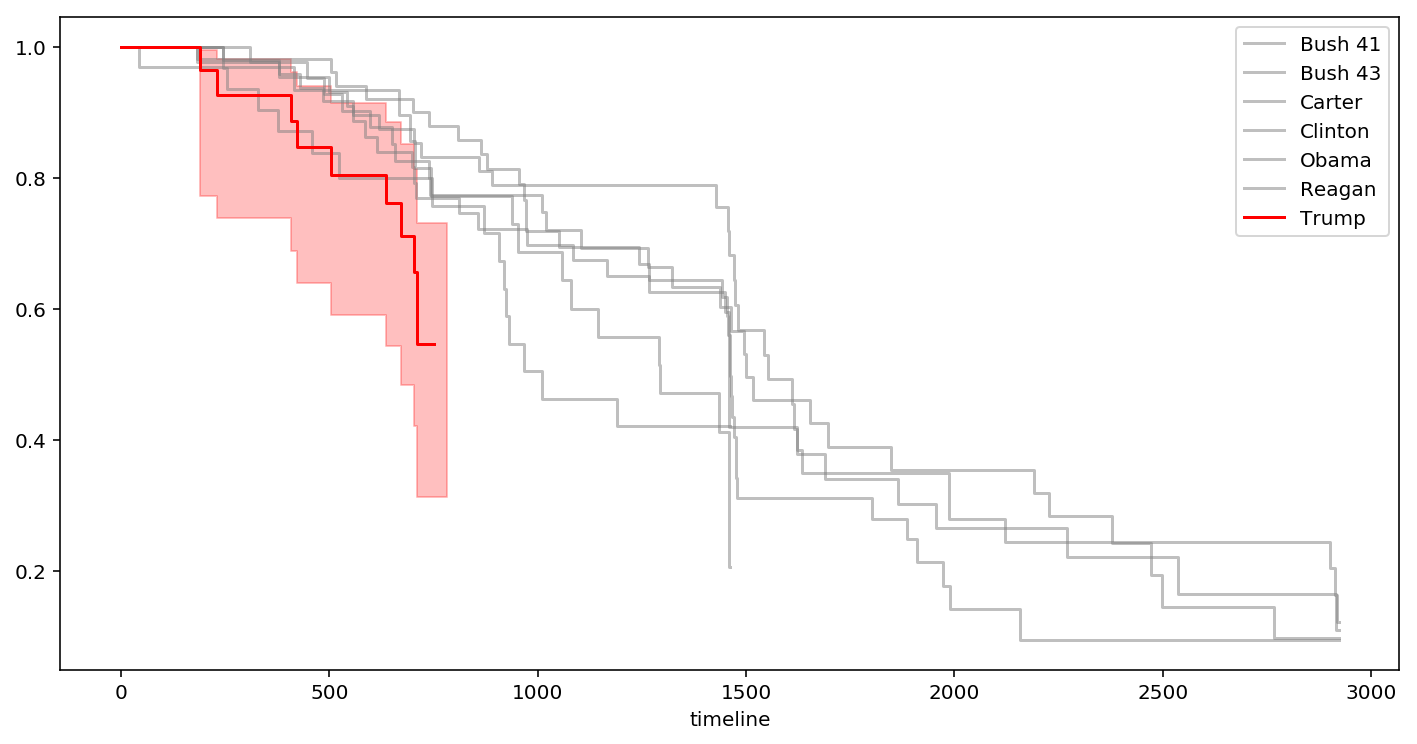

In [9]:
ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    kmf.fit(df_['T'], df_['event'], label=name)
    if name == 'Trump':
        ax = kmf.plot(ax=ax, c='r')
    else:
        ax = kmf.plot(ax=ax, c='grey', alpha=0.5, ci_show=False)


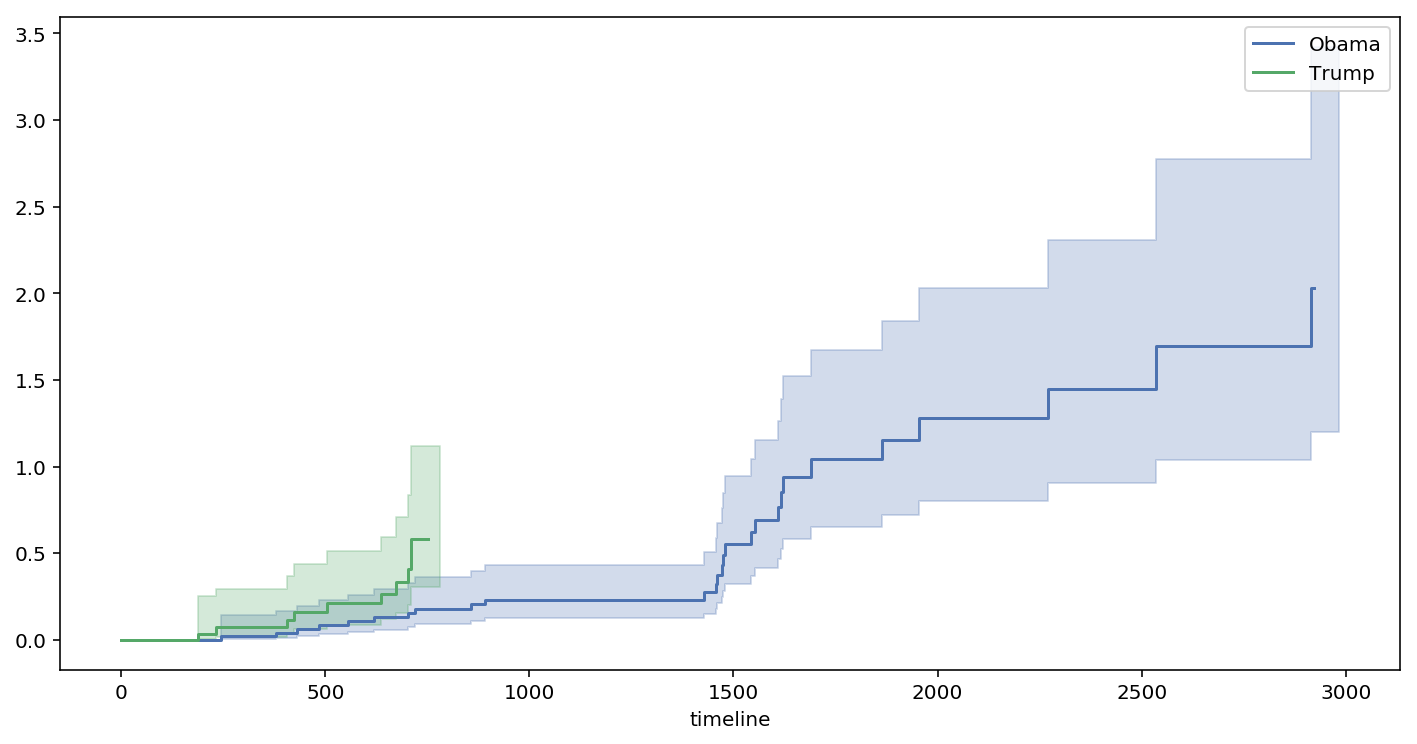

In [21]:
raw_df[['president','event', 'T']]

naf = NelsonAalenFitter()

ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    if name in ['Trump', 'Obama']:
        naf.fit(df_['T'], df_['event'], label=name)
        ax = naf.plot(ax=ax)

In [11]:
raw_df['year'] = raw_df['start'].apply(lambda d: int(d.year))
raw_df['year**2'] = (raw_df['year'] - raw_df['year'].mean())**2



regression_df = raw_df[['president', 'T', 'event', 'year', 'year**2']]
regression_df = pd.get_dummies(regression_df, columns=['president'])
del regression_df['president_Clinton']

In [12]:
cph = CoxPHFitter()
cph.fit(regression_df, 'T', 'event')
cph.print_summary(3)

<lifelines.CoxPHFitter: fitted with 287 observations, 129 censored>
      duration col = 'T'
         event col = 'event'
number of subjects = 287
  number of events = 158
    log-likelihood = -724.380
  time fit was run = 2019-02-12 00:26:21 UTC

---
                    coef  exp(coef)  se(coef)      z     p  -log2(p)  lower 0.95  upper 0.95
year               0.110      1.117     0.059  1.877 0.060     4.048      -0.005       0.225
year**2           -0.005      0.995     0.002 -2.098 0.036     4.800      -0.010      -0.000
president_Bush 41  1.453      4.276     0.489  2.970 0.003     8.390       0.494       2.412
president_Bush 43 -0.628      0.533     0.539 -1.166 0.244     2.038      -1.685       0.428
president_Carter   4.616    101.051     1.432  3.223 0.001     9.624       1.809       7.422
president_Obama   -1.078      0.340     1.043 -1.034 0.301     1.732      -3.122       0.965
president_Reagan   2.375     10.755     0.886  2.681 0.007     7.090       0.639       4.112
pres

In [13]:
cph.check_assumptions(regression_df)

Proportional hazard assumption looks okay.


           year     year**2  president_Bush 41  president_Bush 43  \
year=1977  1977  399.442703           0.111498           0.184669   
year=1987  1987   99.721449           0.111498           0.184669   
year=1997  1997    0.000194           0.111498           0.184669   
year=2007  2007  100.278940           0.111498           0.184669   
year=2017  2017  400.557686           0.111498           0.184669   

           president_Carter  president_Obama  president_Reagan  \
year=1977          0.111498         0.170732          0.170732   
year=1987          0.111498         0.170732          0.170732   
year=1997          0.111498         0.170732          0.170732   
year=2007          0.111498         0.170732          0.170732   
year=2017          0.111498         0.170732          0.170732   

           president_Trump  
year=1977         0.097561  
year=1987         0.097561  
year=1997         0.097561  
year=2007         0.097561  
year=2017         0.097561  


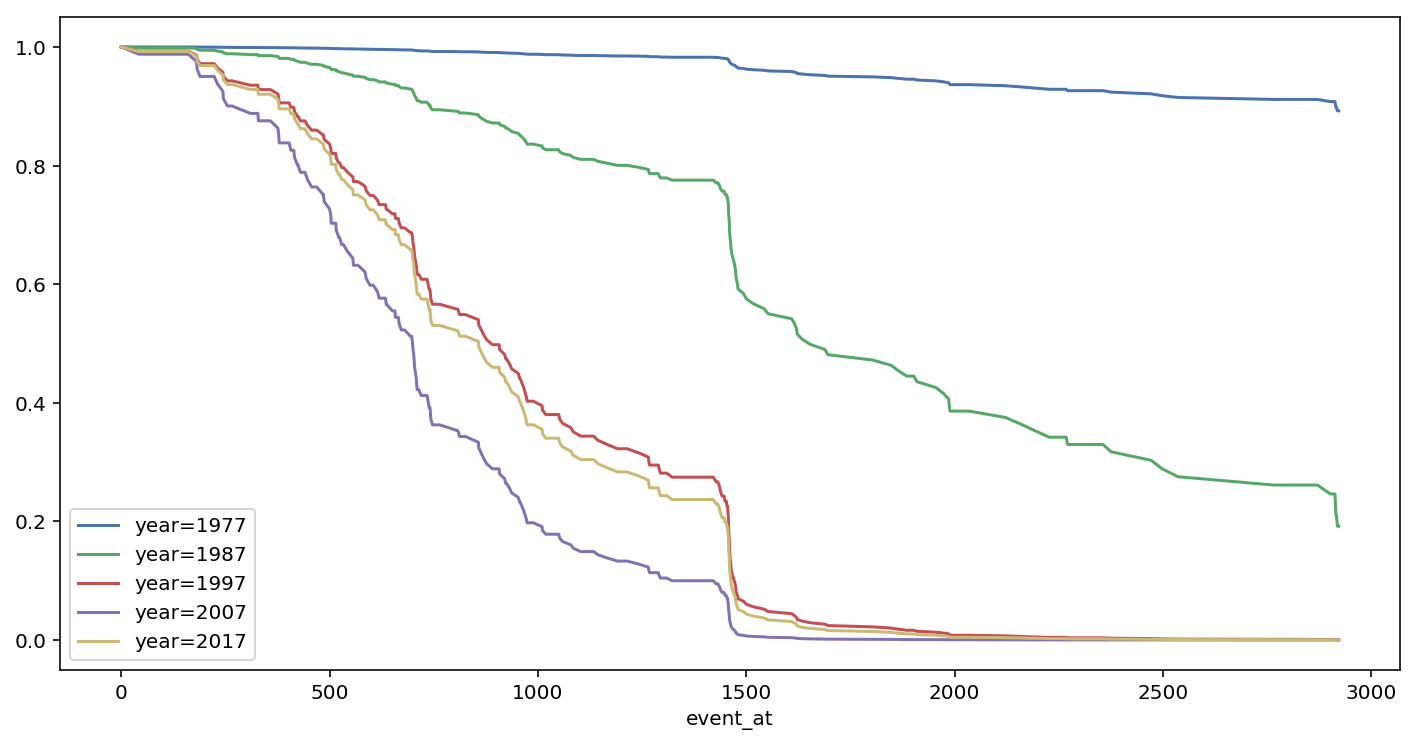

In [14]:
groups = np.arange(1977, 2020, 10)

x_bar = cph._norm_mean.to_frame().T
X = pd.concat([x_bar] * len(groups))
X.index = ["%s=%s" % ('year', g) for g in groups]
X['year'] = groups
X['year**2'] = (groups - raw_df['year'].mean())**2
print(X)
cph.predict_survival_function(X).plot()

In [68]:
# indiv. survival curve for id=284

ix = 280
T = raw_df['T']
E = raw_df['event']
n = T.shape[0]

st = KaplanMeierFitter().fit(T, E).survival_function_
st_minus_i = KaplanMeierFitter().fit(T.drop(ix), E.drop(ix)).survival_function_


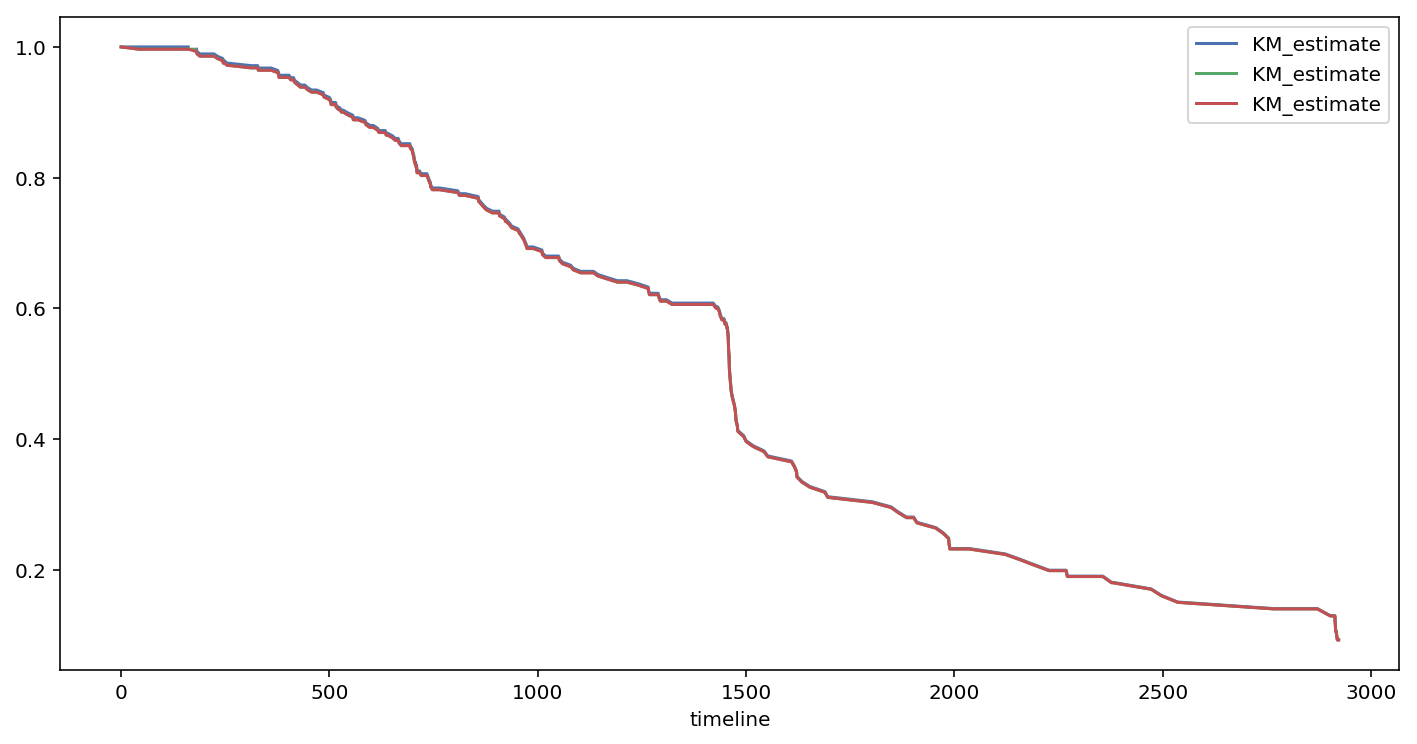

In [69]:
ax = (n * st - (n-1) * st_minus_i).plot(label='st_i')
ax = st.plot(ax=ax)
ax = st_minus_i.plot(ax=ax)

In [71]:
raw_df.loc[ix]

appointee             Robert Wilkie
start                    2018-07-30
end                      2019-01-24
event                         False
president                     Trump
president_end_date       2019-01-24
T                               178
year                           2018
year**2                     441.586
Name: 280, dtype: object

In [72]:
raw_df.loc[284]

appointee             Steve Mnuchin
start                    2017-02-13
end                      2019-01-24
event                         False
president                     Trump
president_end_date       2019-01-24
T                               710
year                           2017
year**2                     400.558
Name: 284, dtype: object